# Single Cell Sequencing: data agregation and quality control USING UMIs

We use Scanpy for quality control filtering of data and for basic analysis (such as dimensionality reduction and plotting).

Adata file format is used as a variable for all the notebook.

We add information from other .txt files that were provided by SciLife lab regarding the real or kept cell barcodes and the mapping from the barcodes to the position in the well.

We use the information of the position in the plate to define which cells were correponding to mock or different stimuli experiments, as well as to include the level of red and green fluorecence of those cells (from CAMPARI).

Output of this notebook is the agreagated and quality controled data saved as campary_scs.h5ad (after quality control)

In [1]:
!pip install --quiet anndata
!pip install scrublet
!pip install scanorama
import os
import config as general_paths
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import anndata as ad
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from matplotlib import rcParams
#doublet detection
#import scrublet as scr
#batch correction (not installed by default in the docker container, install via command line: pip install scanorama bbknn)
#import scanorama as scan
#external modules
import scanpy.external as sce
#pretty plotting
import seaborn as sb
import sys 
sb.set_context(context='poster')

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


  Obtaining dependency information for scrublet from https://files.pythonhosted.org/packages/21/74/82308f7bdcbda730b772a6d1afb6f55b9706601032126c4359afb3fb8986/scrublet-0.2.3-py3-none-any.whl.metadata
  Using cached scrublet-0.2.3-py3-none-any.whl.metadata (3.1 kB)
  Obtaining dependency information for cython from https://files.pythonhosted.org/packages/93/03/e330b241ad8aa12bb9d98b58fb76d4eb7dcbe747479aab5c29fce937b9e7/Cython-3.0.11-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached Cython-3.0.11-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.2 kB)
  Using cached annoy-1.17.3.tar.gz (647 kB)
  Preparing metadata (setup.py) ... done
Using cached scrublet-0.2.3-py3-none-any.whl (15 kB)
Using cached Cython-3.0.11-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [25 lines of output]
      /home/

In [9]:
figure_path = general_paths.figures_path
data_path = general_paths.data_path
output_path = general_paths.output_path
kallsito_path = general_paths.kallisto_path
local_path = general_paths.local_path

### filtering criteria
# possible number of PCA
PCA_NO = 20

MIN_COUNTS = 10000
MIN_GENES = 3000
MIN_CELLS = 5
N_GENES_BY_COUNTS = 12500
HIGHLY_VARIABLE_GENES = 16000
mito_threshold = 5

# Exclude cells that don't express Avil or Syn1
MISSING_GENES = ["Avil", "Syn1"]

# file with not normalized not highly variable genes
campari_raw_file_all_genes = 'campari_raw_all_genes_from_kallisto.h5ad'
campari_raw_file_all_genes_without_excluded_cells = 'campari_raw_all_genes_from_kallisto_excluded_cells_without_some_genes.h5ad'
# file with highly variable genes, log normalizes, regressed and scaled
campari_file = 'campari_from_kallisto.h5ad'
campari_file_without_excluded_cells = 'campari_from_kallisto_excluded_cells_without_some_genes.h5ad'
campari_no_doublets_file = 'campari_from_kallisto_no_doublets.h5ad'

## SECTION I: Data loading, cell selection and data agregation

Here we declare file paths assuming fastq files had been already decompressed. 

We need adata file path (kallisto output), kept cell barcodes file (provided by scilife lab), 
all cell barcodes file (kallisto output), plate-cell barcode ID file (provided by scilife lab),
and flourecence information (file manually created with plate position info, flourence level, and our cell number).

This section loads all these files, and the final output is an anndata format count matrix with data agregation from all plates.

In [14]:
# load the unfiltered matrix and define all paths for storing data

results_file_sample1 = os.path.join(kallsito_path,'sample1/counts_unfiltered_umi/adata.h5ad')  # the file that will store the analysis results
results_file_sample2 = os.path.join(kallsito_path,'sample2/counts_unfiltered_umi/adata.h5ad') # the file that will store the analysis results
results_file_sample3 = os.path.join(kallsito_path,'sample3/counts_unfiltered_umi/adata.h5ad')  # the file that will store the analysis results
results_file_sample4 = os.path.join(kallsito_path,'sample4/counts_unfiltered_umi/adata.h5ad')  # the file that will store the analysis results
results_file_sample5 = os.path.join(kallsito_path,'sample5/counts_unfiltered_umi/adata.h5ad') # the file that will store the analysis results
results_file_sample6 = os.path.join(kallsito_path,'sample6/counts_unfiltered_umi/adata.h5ad') 
results_file_sample7 = os.path.join(kallsito_path,'sample7/counts_unfiltered_umi/adata.h5ad') 
results_file_sample8 = os.path.join(kallsito_path,'sample8/counts_unfiltered_umi/adata.h5ad') 
results_file_sample9 = os.path.join(kallsito_path,'sample9/counts_unfiltered_umi/adata.h5ad') 
results_file_sample10 = os.path.join(kallsito_path,'sample10/counts_unfiltered_umi/adata.h5ad') 


#txt file with kept cells
cell_barcode_file_sample1 = os.path.join(data_path,'sample1/SS3_22_291kept_barcodes.txt')
cell_barcode_file_sample2 = os.path.join(data_path,'sample2/SS3_23_049kept_barcodes.txt')
cell_barcode_file_sample3 = os.path.join(data_path,'sample3/SS3_23_127kept_barcodes.txt')
cell_barcode_file_sample4 = os.path.join(data_path,'sample4/SS3_23_193kept_barcodes.txt')
cell_barcode_file_sample5 = os.path.join(data_path,'sample5/SS3_23_195kept_barcodes.txt')
cell_barcode_file_sample6 = os.path.join(data_path,'sample6/SS3_23_325kept_barcodes.txt')
cell_barcode_file_sample7 = os.path.join(data_path,'sample7/SS3_23_327kept_barcodes.txt')
cell_barcode_file_sample8 = os.path.join(data_path,'sample8/P30855_101kept_barcodes.txt')
cell_barcode_file_sample9 = os.path.join(data_path,'sample9/P30855_103kept_barcodes.txt')
cell_barcode_file_sample10 = os.path.join(data_path,'sample10/P30855_105kept_barcodes.txt')


#read barcodes with kalisto
cell_barcode_file_new_sample1 = os.path.join(kallsito_path,'sample1/counts_unfiltered_umi/cells_x_genes.barcodes.txt')
cell_barcode_file_new_sample2 = os.path.join(kallsito_path,'sample2/counts_unfiltered_umi/cells_x_genes.barcodes.txt')
cell_barcode_file_new_sample3 = os.path.join(kallsito_path,'sample3/counts_unfiltered_umi/cells_x_genes.barcodes.txt')
cell_barcode_file_new_sample4 = os.path.join(kallsito_path,'sample4/counts_unfiltered_umi/cells_x_genes.barcodes.txt')
cell_barcode_file_new_sample5 = os.path.join(kallsito_path,'sample5/counts_unfiltered_umi/cells_x_genes.barcodes.txt')
cell_barcode_file_new_sample6 = os.path.join(kallsito_path,'sample6/counts_unfiltered_umi/cells_x_genes.barcodes.txt')
cell_barcode_file_new_sample7 = os.path.join(kallsito_path,'sample7/counts_unfiltered_umi/cells_x_genes.barcodes.txt')
cell_barcode_file_new_sample8 = os.path.join(kallsito_path,'sample8/counts_unfiltered_umi/cells_x_genes.barcodes.txt')
cell_barcode_file_new_sample9 = os.path.join(kallsito_path,'sample9/counts_unfiltered_umi/cells_x_genes.barcodes.txt')
cell_barcode_file_new_sample10 = os.path.join(kallsito_path,'sample10/counts_unfiltered_umi/cells_x_genes.barcodes.txt')

#txt file with well barcodes. the text contains the cell barcode corresponding to each position in the plate
well_barcode_sample1 = os.path.join(data_path,'sample1/SS3_22_291.well_barcodes.txt')
well_barcode_sample2 = os.path.join(data_path,'sample2/SS3_23_049.well_barcodes.txt')
well_barcode_sample3 = os.path.join(data_path,'sample3/SS3_23_127.well_barcodes.txt')
well_barcode_sample4 = os.path.join(data_path,'sample4/SS3_23_193.well_barcodes.txt')
well_barcode_sample5 = os.path.join(data_path,'sample5/SS3_23_195.well_barcodes.txt')
well_barcode_sample6 = os.path.join(data_path,'sample6/SS3_23_325.well_barcodes.txt')
well_barcode_sample7 = os.path.join(data_path,'sample7/SS3_23_327.well_barcodes.txt')
well_barcode_sample8 = os.path.join(data_path,'sample8/P30855_101.well_barcodes.txt')
well_barcode_sample9 = os.path.join(data_path,'sample9/P30855_103.well_barcodes.txt')
well_barcode_sample10 = os.path.join(data_path,'sample10/P30855_105.well_barcodes.txt')

###upload excel with red and green flourecence from campari (has information about position in plate and fluorecence level)
florecence_1_file_path =os.path.join(data_path,'data_base/well_1_data_base.csv')
florecence_2_file_path = os.path.join(data_path,'data_base/well_2_data_base.csv')
florecence_3_file_path = os.path.join(data_path,'data_base/well_3_data_base.csv')
florecence_4_file_path = os.path.join(data_path,'data_base/well_4_data_base.csv')
florecence_5_file_path = os.path.join(data_path,'data_base/well_5_data_base.csv')
florecence_6_file_path = os.path.join(data_path,'data_base/well_6_data_base.csv')
florecence_7_file_path = os.path.join(data_path,'data_base/well_7_data_base.csv')
florecence_8_file_path = os.path.join(data_path,'data_base/well_8_data_base.csv')
florecence_9_file_path = os.path.join(data_path,'data_base/well_9_data_base.csv')
florecence_10_file_path = os.path.join(data_path,'data_base/well_10_data_base.csv')

In [15]:
### load raw adata file using adata libraty
sample1 = ad.read_h5ad(results_file_sample1)
sample2 = ad.read_h5ad(results_file_sample2)
sample3 = ad.read_h5ad(results_file_sample3)
sample4 = ad.read_h5ad(results_file_sample4)
sample5 = ad.read_h5ad(results_file_sample5)
sample6 = ad.read_h5ad(results_file_sample6)
sample7 = ad.read_h5ad(results_file_sample7)
sample8 = ad.read_h5ad(results_file_sample8)
sample9 = ad.read_h5ad(results_file_sample9)
sample10 = ad.read_h5ad(results_file_sample10)

### read fluorecence levels
flourecence1 = pd.read_csv(florecence_1_file_path)
flourecence2 = pd.read_csv(florecence_2_file_path)
flourecence3 = pd.read_csv(florecence_3_file_path)
flourecence4 = pd.read_csv(florecence_4_file_path)
flourecence5 = pd.read_csv(florecence_5_file_path)
flourecence6 = pd.read_csv(florecence_6_file_path)
flourecence7 = pd.read_csv(florecence_7_file_path)
flourecence8 = pd.read_csv(florecence_8_file_path)
flourecence9 = pd.read_csv(florecence_9_file_path)
flourecence10 = pd.read_csv(florecence_10_file_path)


### read kept barcodes and barcodes provided by kalisto
df_1_sample1 = pd.read_csv(cell_barcode_file_sample1, delimiter = "\,")
df_2_sample1 = pd.read_csv(cell_barcode_file_new_sample1)

df_1_sample2 = pd.read_csv(cell_barcode_file_sample2, delimiter = "\,")
df_2_sample2 = pd.read_csv(cell_barcode_file_new_sample2)

df_1_sample3 = pd.read_csv(cell_barcode_file_sample3, delimiter = "\,")
df_2_sample3 = pd.read_csv(cell_barcode_file_new_sample3)

df_1_sample4 = pd.read_csv(cell_barcode_file_sample4, delimiter = "\,")
df_2_sample4 = pd.read_csv(cell_barcode_file_new_sample4)

df_1_sample5 = pd.read_csv(cell_barcode_file_sample5, delimiter = "\,")
df_2_sample5 = pd.read_csv(cell_barcode_file_new_sample5)

df_1_sample6 = pd.read_csv(cell_barcode_file_sample6, delimiter = "\,")
df_2_sample6 = pd.read_csv(cell_barcode_file_new_sample6)

df_1_sample7 = pd.read_csv(cell_barcode_file_sample7, delimiter = "\,")
df_2_sample7 = pd.read_csv(cell_barcode_file_new_sample7)

df_1_sample8 = pd.read_csv(cell_barcode_file_sample8, delimiter = "\,")
df_2_sample8 = pd.read_csv(cell_barcode_file_new_sample8)

df_1_sample9 = pd.read_csv(cell_barcode_file_sample9, delimiter = "\,")
df_2_sample9 = pd.read_csv(cell_barcode_file_new_sample9)

df_1_sample10 = pd.read_csv(cell_barcode_file_sample10, delimiter = "\,")
df_2_sample10 = pd.read_csv(cell_barcode_file_new_sample10)


/tmp/ipykernel_30555/812971396.py:27: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_1_sample1 = pd.read_csv(cell_barcode_file_sample1, delimiter = "\,")
/tmp/ipykernel_30555/812971396.py:30: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_1_sample2 = pd.read_csv(cell_barcode_file_sample2, delimiter = "\,")
/tmp/ipykernel_30555/812971396.py:33: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_1_sample3 = pd.r

In [50]:
### merge data base. Merge information about cell barcode and fluorecence 
### (using as common demonimator the position in the plate)
barcode_list_sample1 = list(df_1_sample1['XC'])
well_df_sample1 = pd.read_csv(well_barcode_sample1, delimiter = "\t")
mergedRes1 = pd.merge(well_df_sample1 , flourecence1, on ='well_id')

barcode_list_sample2 = list(df_1_sample2['XC'])
well_df_sample2 = pd.read_csv(well_barcode_sample2, delimiter = "\t")
mergedRes2 = pd.merge(well_df_sample2 , flourecence2, on ='well_id')

barcode_list_sample3 = list(df_1_sample3['XC'])
well_df_sample3 = pd.read_csv(well_barcode_sample3, delimiter = "\t")
mergedRes3 = pd.merge(well_df_sample3 , flourecence3, on ='well_id')

barcode_list_sample4 = list(df_1_sample4['XC'])
well_df_sample4 = pd.read_csv(well_barcode_sample4, delimiter = "\t")
mergedRes4 = pd.merge(well_df_sample4 , flourecence4, on ='well_id')

barcode_list_sample5 = list(df_1_sample5['XC'])
well_df_sample5 = pd.read_csv(well_barcode_sample5, delimiter = "\t")
mergedRes5 = pd.merge(well_df_sample5 , flourecence5, on ='well_id')

barcode_list_sample6 = list(df_1_sample6['XC'])
well_df_sample6 = pd.read_csv(well_barcode_sample6, delimiter = "\t")
mergedRes6 = pd.merge(well_df_sample6 , flourecence6, on ='well_id')

barcode_list_sample7 = list(df_1_sample7['XC'])
well_df_sample7 = pd.read_csv(well_barcode_sample7, delimiter = "\t")
mergedRes7 = pd.merge(well_df_sample7 , flourecence7, on ='well_id')

barcode_list_sample8 = list(df_1_sample8['XC'])
well_df_sample8 = pd.read_csv(well_barcode_sample8, delimiter = "\t")
mergedRes8 = pd.merge(well_df_sample8 , flourecence8, on ='well_id')

barcode_list_sample9 = list(df_1_sample9['XC'])
well_df_sample9 = pd.read_csv(well_barcode_sample9, delimiter = "\t")
mergedRes9 = pd.merge(well_df_sample9 , flourecence9, on ='well_id')

barcode_list_sample10 = list(df_1_sample10['XC'])
well_df_sample10 = pd.read_csv(well_barcode_sample10, delimiter = "\t")
mergedRes10 = pd.merge(well_df_sample10 , flourecence10, on ='well_id')

# make names unique
sample1.var_names_make_unique()
sample2.var_names_make_unique()
sample3.var_names_make_unique()
sample4.var_names_make_unique()
sample5.var_names_make_unique()
sample6.var_names_make_unique()
sample7.var_names_make_unique()
sample8.var_names_make_unique()
sample9.var_names_make_unique()
sample10.var_names_make_unique()

#Create a plot showing genes detected as a function of UMI counts.
def plot_counts(adata,plot_title):
    fig, ax = plt.subplots(1,3)
    x = np.asarray(adata.X.sum(axis=1))[:,0]
    y = np.asarray(np.sum(adata.X>0, axis=1))[:,0]
    ax[0].scatter(x, y, color="b", alpha=0.25)
    ax[0].set_ylabel("Genes Detected")
    ax[0].set_xlabel("UMI Counts")
    #ax.set_xscale('log')
    #ax.set_yscale('log')

    #histogram definition
    bins = [1500, 1500] # number of bins
    # histogram the data
    hh, locx, locy = np.histogram2d(x, y, bins=bins)
    # Sort the points by density, so that the densest points are plotted last
    z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
    idx = z.argsort()
    x2, y2, z2 = x[idx], y[idx], z[idx]

    s = ax[1].scatter(x2, y2, c=z2, cmap='Greens')  
    fig.colorbar(s, ax=ax)

    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_xlabel("UMI Counts")
    ax[1].set_ylabel("Genes Detected")


    expected_num_cells =  380#@param {type:"integer"}
    knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

    ax[2].loglog(knee, range(len(knee)), linewidth=5, color="g")
    ax[2].axvline(x=knee[expected_num_cells], linewidth=2, color="k")
    ax[2].axhline(y=expected_num_cells, linewidth=2, color="k")

    ax[2].set_xlabel("UMI Counts")
    ax[2].set_ylabel("Set of Barcodes")

    #plt.grid(True, which="both")

    fig.set_size_inches([20,3])
    plt.show()
    # fig.savefig(os.path.join(figure_path , 'QC_UMI_genes_counts_pre_filtering.png'))
    
    

In [56]:
t2g = pd.read_csv("t2g.txt", header=None,  names=["tid", "gene_id", "gene_name", "gene_variant","num1","num2","num3","pos_neg"], sep="\t")
t2g.index = t2g.gene_id### FOR THAT WE USE T2G VARIABLE THAT OPENS T2G FILE (FILE WITH LINK BETWEEN GENE CODE AND GENE NAME)
print(len(t2g))
t2g = t2g.loc[~t2g.index.duplicated(keep='first')]
print(len(t2g))

# Some of the gene ids don't have gene names in the t2g file from kallisto
# replace those missing gene names with their ids
def replace_nan_gene_names_with_gene_id(adata_object):
    ctr = 0
    fixed_gene_names = []
    for i, gene in enumerate(adata_object.var["gene_name"].values):
        gene_name = gene
        if gene is np.nan:
            ctr +=1
            gene_name = adata_object.var["gene_id"].values[i]
        fixed_gene_names.append(gene_name)
    print(f"{ctr} missing gene names")
    # replace the list of gene ids with nans with a list of gene names or gene ids
    adata_object.var["gene_name"] = fixed_gene_names
    return adata_object

sample1.var["gene_id"] = sample1.var.index.values
sample1.var["gene_name"] = sample1.var.gene_id.map(t2g["gene_name"])

sample2.var["gene_id"] = sample2.var.index.values
sample2.var["gene_name"] = sample2.var.gene_id.map(t2g["gene_name"])

sample3.var["gene_id"] = sample3.var.index.values
sample3.var["gene_name"] = sample3.var.gene_id.map(t2g["gene_name"])

sample4.var["gene_id"] = sample4.var.index.values
sample4.var["gene_name"] = sample4.var.gene_id.map(t2g["gene_name"])

sample5.var["gene_id"] = sample5.var.index.values
sample5.var["gene_name"] = sample5.var.gene_id.map(t2g["gene_name"])

sample6.var["gene_id"] = sample6.var.index.values
sample6.var["gene_name"] = sample6.var.gene_id.map(t2g["gene_name"])

sample7.var["gene_id"] = sample7.var.index.values
sample7.var["gene_name"] = sample7.var.gene_id.map(t2g["gene_name"])

sample8.var["gene_id"] = sample8.var.index.values
sample8.var["gene_name"] = sample8.var.gene_id.map(t2g["gene_name"])

sample9.var["gene_id"] = sample9.var.index.values
sample9.var["gene_name"] = sample9.var.gene_id.map(t2g["gene_name"])

sample10.var["gene_id"] = sample10.var.index.values
sample10.var["gene_name"] = sample10.var.gene_id.map(t2g["gene_name"])

# replace missing gene names with their ids
sample1 = replace_nan_gene_names_with_gene_id(sample1)
sample1.var.index = sample1.var["gene_name"]

sample2 = replace_nan_gene_names_with_gene_id(sample2)
sample2.var.index = sample2.var["gene_name"]

sample3 = replace_nan_gene_names_with_gene_id(sample3)
sample3.var.index = sample3.var["gene_name"]

sample4 = replace_nan_gene_names_with_gene_id(sample4)
sample4.var.index = sample4.var["gene_name"]

sample5 = replace_nan_gene_names_with_gene_id(sample5)
sample5.var.index = sample5.var["gene_name"]

sample6 = replace_nan_gene_names_with_gene_id(sample6)
sample6.var.index = sample6.var["gene_name"]

sample7 = replace_nan_gene_names_with_gene_id(sample7)
sample7.var.index = sample7.var["gene_name"]

sample8 = replace_nan_gene_names_with_gene_id(sample8)
sample8.var.index = sample8.var["gene_name"]

sample9 = replace_nan_gene_names_with_gene_id(sample9)
sample9.var.index = sample9.var["gene_name"]

sample10 = replace_nan_gene_names_with_gene_id(sample10)
sample10.var.index = sample10.var["gene_name"]

# make names unique
sample1.var_names_make_unique()
sample2.var_names_make_unique()
sample3.var_names_make_unique()
sample4.var_names_make_unique()
sample5.var_names_make_unique()
sample6.var_names_make_unique()
sample7.var_names_make_unique()
sample8.var_names_make_unique()
sample9.var_names_make_unique()
sample10.var_names_make_unique()

/tmp/ipykernel_30555/1424556611.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  t2g = pd.read_csv("t2g.txt", header=None,  names=["tid", "gene_id", "gene_name", "gene_variant","num1","num2","num3","pos_neg"], sep="\t")


126126
34183
34183 missing gene names
34183 missing gene names
34183 missing gene names
34183 missing gene names
34183 missing gene names
34183 missing gene names
34183 missing gene names
34183 missing gene names
34183 missing gene names
34183 missing gene names


In [57]:
def barcode_check(df_1,df_2,barcode_list,mergedRes):

    #print(barcode_list)
    kept_cells = np.zeros((len(df_1),))
    well_id = np.zeros((len(df_1),))

    red_f = np.zeros((len(df_1),))
    green_f = np.zeros((len(df_1),))
    stimulus = np.zeros((len(df_1),))
    cell_id = np.zeros((len(df_1),))

    index_vector = np.zeros((len(df_1),))
    count = 0
    counter = 0
    for i in range(len(df_2)):
        x = df_2.iloc[i]['Barcodes']
        if x in barcode_list:
            index = barcode_list.index(x)
            index_vector[count] = index
            if len(np.where(np.isnan(mergedRes['stimulus'].where(mergedRes['bc_set'] == x))==False)):
                counter+=1
                position = np.where(np.isnan(mergedRes['stimulus'].where(mergedRes['bc_set'] == x))==False)[0][0]
                stimulus[index] = mergedRes['stimulus'].where(mergedRes['bc_set'] == x)[position]
                red_f[index] = mergedRes['red_f'].where(mergedRes['bc_set'] == x)[position]
                green_f[index] = mergedRes['green_f'].where(mergedRes['bc_set'] == x)[position]
                cell_id[index] = mergedRes['cell_number'].where(mergedRes['bc_set'] == x)[position]
                kept_cells[index] = int(i)
                well_id[index] = 1
                count +=1
    #kept_cells = np.unique(kept_cells)
    count = len(df_1)
    
    return kept_cells, well_id,stimulus,red_f,green_f, cell_id

In [58]:
# add some metadata
sample1.obs['sample']="Sample_1"
sample2.obs['sample']="Sample_2"
sample3.obs['sample']="Sample_3"
sample4.obs['sample']="Sample_4"
sample5.obs['sample']="Sample_5"
sample6.obs['sample']="Sample_6"
sample7.obs['sample']="Sample_7"
sample8.obs['sample']="Sample_8"
sample9.obs['sample']="Sample_9"
sample10.obs['sample']="Sample_10"

In [59]:
kept_cells1, well_id1,stimulus_1,red_f1,green_f1, cell_id1 = barcode_check(df_1_sample1,df_2_sample1,barcode_list_sample1,mergedRes1)
kept_cells2, well_id2,stimulus_2,red_f2,green_f2, cell_id2 = barcode_check(df_1_sample2,df_2_sample2,barcode_list_sample2,mergedRes2)
kept_cells3, well_id3,stimulus_3,red_f3,green_f3, cell_id3 = barcode_check(df_1_sample3,df_2_sample3,barcode_list_sample3,mergedRes3)
kept_cells4, well_id4,stimulus_4,red_f4,green_f4, cell_id4 = barcode_check(df_1_sample4,df_2_sample4,barcode_list_sample4,mergedRes4)
kept_cells5, well_id5,stimulus_5,red_f5,green_f5, cell_id5 = barcode_check(df_1_sample5,df_2_sample5,barcode_list_sample5,mergedRes5)

kept_cells6, well_id6,stimulus_6,red_f6,green_f6, cell_id6 = barcode_check(df_1_sample6,df_2_sample6,barcode_list_sample6,mergedRes6)
kept_cells7, well_id7,stimulus_7,red_f7,green_f7, cell_id7 = barcode_check(df_1_sample7,df_2_sample7,barcode_list_sample7,mergedRes7)
kept_cells8, well_id8,stimulus_8,red_f8,green_f8, cell_id8 = barcode_check(df_1_sample8,df_2_sample8,barcode_list_sample8,mergedRes8)
kept_cells9, well_id9,stimulus_9,red_f9,green_f9, cell_id9 = barcode_check(df_1_sample9,df_2_sample9,barcode_list_sample9,mergedRes9)
kept_cells10, well_id10,stimulus_10,red_f10,green_f10, cell_id10 = barcode_check(df_1_sample10,df_2_sample10,barcode_list_sample10,mergedRes10)


In [60]:
### select only kept cells
sample1.var_names_make_unique() 
sample2.var_names_make_unique() 
sample3.var_names_make_unique() 
sample4.var_names_make_unique() 
sample5.var_names_make_unique() 
sample6.var_names_make_unique() 
sample7.var_names_make_unique() 
sample8.var_names_make_unique() 
sample9.var_names_make_unique() 
sample10.var_names_make_unique() 

adata1 = sample1[kept_cells1.astype(int),:]
adata2 = sample2[kept_cells2.astype(int),:]
adata3 = sample3[kept_cells3.astype(int),:]
adata4 = sample4[kept_cells4.astype(int),:]
adata5 = sample5[kept_cells5.astype(int),:]
adata6 = sample6[kept_cells6.astype(int),:]
adata7 = sample7[kept_cells7.astype(int),:]
adata8 = sample8[kept_cells8.astype(int),:]
adata9 = sample9[kept_cells9.astype(int),:]
adata10 = sample10[kept_cells10.astype(int),:]

In [61]:
### add campari information to adata structure
adata1.obs['stimulus'] = stimulus_1 
adata1.obs['red'] = red_f1
adata1.obs['green'] = green_f1
adata1.obs['well_id'] = well_id1
adata1.obs['cell_id'] = cell_id1

adata2.obs['stimulus'] = stimulus_2
adata2.obs['red'] = red_f2
adata2.obs['green'] = green_f2
adata2.obs['well_id'] = well_id2
adata2.obs['cell_id'] = cell_id3

adata3.obs['stimulus'] = stimulus_3
adata3.obs['red'] = red_f3
adata3.obs['green'] = green_f3
adata3.obs['well_id'] = well_id3
adata3.obs['cell_id'] = cell_id3

adata4.obs['stimulus'] = stimulus_4
adata4.obs['red'] = red_f4
adata4.obs['green'] = green_f4
adata4.obs['well_id'] = well_id4
adata4.obs['cell_id'] = cell_id4

adata5.obs['stimulus'] = stimulus_5
adata5.obs['red'] = red_f5
adata5.obs['green'] = green_f5
adata5.obs['well_id'] = well_id5
adata5.obs['cell_id'] = cell_id5

adata6.obs['stimulus'] = stimulus_6
adata6.obs['red'] = red_f6
adata6.obs['green'] = green_f6
adata6.obs['well_id'] = well_id6
adata6.obs['cell_id'] = cell_id6

adata7.obs['stimulus'] = stimulus_7
adata7.obs['red'] = red_f7
adata7.obs['green'] = green_f7
adata7.obs['well_id'] = well_id7
adata7.obs['cell_id'] = cell_id7

adata8.obs['stimulus'] = stimulus_8
adata8.obs['red'] = red_f8
adata8.obs['green'] = green_f8
adata8.obs['well_id'] = well_id8
adata8.obs['cell_id'] = cell_id8

adata9.obs['stimulus'] = stimulus_9
adata9.obs['red'] = red_f9
adata9.obs['green'] = green_f9
adata9.obs['well_id'] = well_id9
adata9.obs['cell_id'] = cell_id9

adata10.obs['stimulus'] = stimulus_10
adata10.obs['red'] = red_f10
adata10.obs['green'] = green_f10
adata10.obs['well_id'] = well_id10
adata10.obs['cell_id'] = cell_id10

/tmp/ipykernel_30555/4142610235.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata1.obs['stimulus'] = stimulus_1
/home/melma31/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/melma31/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_30555/4142610235.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata2.obs['stimulus'] = stimulus_2
/home/melma31/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_dupl

In [62]:
### data integration

adata_1 = adata1.concatenate(adata2, join='outer', batch_categories=['sample1', 'sample2'], index_unique='-')
adata_2 = adata_1.concatenate(adata3, join='outer', batch_categories=['sample12', 'sample3'], index_unique='-')
adata_3 = adata_2.concatenate(adata4, join='outer', batch_categories=['sample123', 'sample4'], index_unique='-')
adata_4 = adata_3.concatenate(adata5, join='outer', batch_categories=['sample1234', 'sample5'], index_unique='-')
adata_5 = adata_4.concatenate(adata6, join='outer', batch_categories=['sample12345', 'sample6'], index_unique='-')
adata_6 = adata_5.concatenate(adata7, join='outer', batch_categories=['sample123456', 'sample7'], index_unique='-')
adata_7 = adata_6.concatenate(adata8, join='outer', batch_categories=['sample1234567', 'sample8'], index_unique='-')
adata_8 = adata_7.concatenate(adata9, join='outer', batch_categories=['sample12345678', 'sample9'], index_unique='-')
adata_9 = adata_8.concatenate(adata10, join='outer', batch_categories=['sample123456789', 'sample10'], index_unique='-')

adata = adata_9.copy()
adata.var_names_make_unique() 
print('Number of cells:', adata.X.shape[0])
print('Number of genes:', adata.X.shape[1])

# how many cells in each sample
print(adata.obs['sample'].value_counts()) 
adata

/home/melma31/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/melma31/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/melma31/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/melma31/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/melma31/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are n

Number of cells: 3840
Number of genes: 34183
Sample_1     384
Sample_2     384
Sample_3     384
Sample_4     384
Sample_5     384
Sample_6     384
Sample_7     384
Sample_8     384
Sample_9     384
Sample_10    384
Name: sample, dtype: int64


/home/melma31/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 3840 × 34183
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'cell_id', 'batch'
    var: 'gene_id-sample10', 'gene_name-sample10', 'gene_id-sample1234567-sample12345678-sample123456789', 'gene_name-sample1234567-sample12345678-sample123456789', 'gene_id-sample8-sample12345678-sample123456789', 'gene_name-sample8-sample12345678-sample123456789', 'gene_id-sample9-sample123456789', 'gene_name-sample9-sample123456789'

In [63]:
adata.write_h5ad(
    os.path.join(output_path , 'campari_scs_raw.h5ad'),
#    compression=hdf5plugin.FILTERS["zstd"],
#    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)

In [64]:
### WE NEED TO CONVERT CODENAMES INTO REAL GENE NAMES
### FOR THAT WE USE T2G VARIABLE THAT OPENS T2G FILE (FILE WITH LINK BETWEEN GENE CODE AND GENE NAME)

t2g = pd.read_csv("t2g.txt", header=None,  names=["tid", "gene_id", "gene_name", "gene_variant","num1","num2","num3","pos_neg"], sep="\t")
t2g.index = t2g.gene_id### FOR THAT WE USE T2G VARIABLE THAT OPENS T2G FILE (FILE WITH LINK BETWEEN GENE CODE AND GENE NAME)
print(len(t2g))
t2g = t2g.loc[~t2g.index.duplicated(keep='first')]
print(len(t2g))

adata.var["gene_id"] = adata.var.index.values
adata.var["gene_name"] = adata.var.gene_id.map(t2g["gene_name"])

# Some of the gene ids don't have gene names in the t2g file from kallisto
# replace those missing gene names with their ids
def replace_nan_gene_names_with_gene_id(adata_object):
    ctr = 0
    fixed_gene_names = []
    for i, gene in enumerate(adata_object.var["gene_name"].values):
        gene_name = gene
        if gene is np.nan:
            ctr +=1
            gene_name = adata_object.var["gene_id"].values[i]
        fixed_gene_names.append(gene_name)
    print(f"{ctr} missing gene names")
    # replace the list of gene ids with nans with a list of gene names or gene ids
    adata_object.var["gene_name"] = fixed_gene_names
    return adata_object

# replace missing gene names with their ids
adata = replace_nan_gene_names_with_gene_id(adata)
adata.var.index = adata.var["gene_name"]

adata.var["gene_name"].values
# make names unique
adata.var_names_make_unique()
'Piezo1' in adata.var['gene_name'] # check if Piezo1 is there

126126
34183
34183 missing gene names


/tmp/ipykernel_30555/556987761.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  t2g = pd.read_csv("t2g.txt", header=None,  names=["tid", "gene_id", "gene_name", "gene_variant","num1","num2","num3","pos_neg"], sep="\t")


True

total mitochondrial: 13
normalizing counts per cell
    finished (0:00:00)


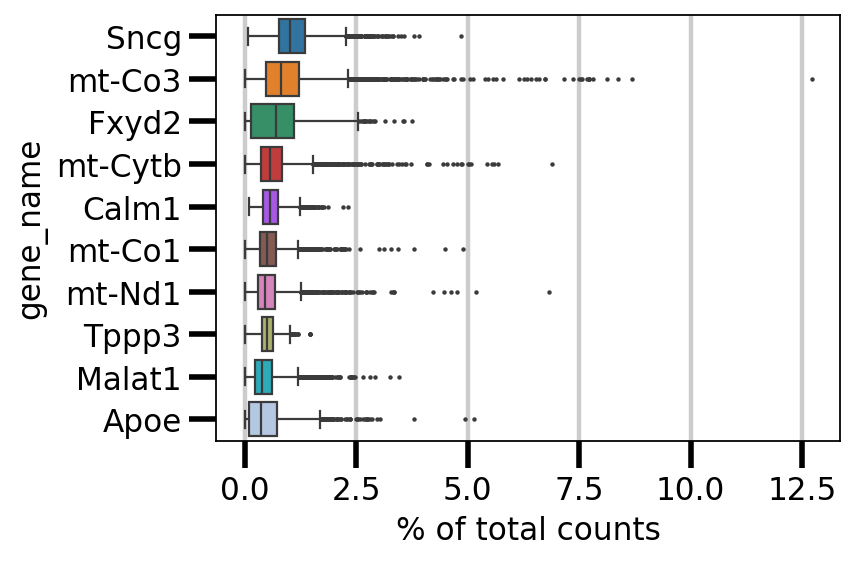

In [65]:
adata
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(axis = 1)
x =  adata.X.sum(axis = 1)
adata.obs['log_counts'] = np.log(x)
adata.obs['n_genes'] = (adata.X > 0).sum(axis = 1)
cnt = 0
for gene in adata.var["gene_name"].values:
    if gene.startswith('mt-'):
        cnt+=1
print(f"total mitochondrial: {cnt}")
sc.pl.highest_expr_genes(adata, n_top=10, )

### ADD STIMULUS NAME

* 0: control
* 1: pinch
* 2: new_stroke (after december)
* 3: ballon
* 4: AG (ano-genital brush)
* 5: AD (anal distension)
* 6: heating
* 7: mock
* 8: old_stoke (first experiments with stroke)
* 9: anal pinch
* 10: mock with poop
* 11: vaginal distansion
* 12: tomatoe
* 13: poop
* 14: Bladder
* 15: Colon-rectum distension (CRD)
* 16: AD + CFA (anal distension + inflamation)
* 17: AGB + CFA (ano-genital brush + inflamation)
* 18: Heating + CFA (heating + inflamation)
* 19: Tail Brush
* 20: TRPM8 td Tomato
* 21: AD + Pulse
* 22: AGB-CFA 1 W
* 23: AD-CFA 1W
* 24: HP
* 25: Penis
* 26: Clitoris Vibration
* 27: Max Cells
* 28: Tracing Ano Genital Skin injection
* 29: Crazy Mock
* 30: Tracing Anal injection
* 31: Tracing Vagina
* 32: Brush Blink test
* 33: Tracing colon
* 34: Tracing bladder
* 36: Tracing bladder / colon
* 37: NEFH cells
* -1: empty


In [66]:
labels=['Control','Pinch','New_stroke','Ballon','AG','AD','Heating','Mock','Old_stroke','Anal_pinch','Mock_w_poop','Vaginal_distension','Tomato','Poop', 
        'Bladder','CRD','AD+CFA','AGB+CFA','Heating+CFA','Tail Brush','TRPM8 td tomato',
        'AD + Pulse', 'AGB+CFA 1 W','AD+CFA 1W','HP','Penis','Clitoris Vibration','Max Cells',
        'Tracing Ano Genital Skin injection','Crazy Mock','Tracing Anal injection', 'Tracing Vagina',
       'Brush_BlinkTest','TracingC','TracingB','TracingBC','NEFH','empty']
stim_str = ['0', '1', '2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22',
            '23','24','25','26','27','28','29','30','31','32','33','34','36','37','-1']



# create category type obs variable that will be used for ranking
adata.obs['stimulus_name'] = adata.obs['stimulus'].astype('category') # copy stimulus data to new obs for ranking 
new_values = [str(int(el)) for el in adata.obs['stimulus_name'].values]    # convert stimulus to string categories
adata.obs['stimulus_name'] = new_values                                    # replace float values with new string values (changed type to object)
adata.obs['stimulus_name'].astype('category')                              # make it category type again

barcode
TCCGATAACTCACTAACCGG-sample1-sample12-sample123-sample1234-sample12345-sample123456-sample1234567-sample12345678-sample123456789    1
TCCGATAACTCACAATCCAC-sample1-sample12-sample123-sample1234-sample12345-sample123456-sample1234567-sample12345678-sample123456789    1
TTCACCACGGCACAATCCAC-sample1-sample12-sample123-sample1234-sample12345-sample123456-sample1234567-sample12345678-sample123456789    1
TTCACCACGGCACTAACCGG-sample1-sample12-sample123-sample1234-sample12345-sample123456-sample1234567-sample12345678-sample123456789    1
TTCACCAGCTCACTAACCGG-sample1-sample12-sample123-sample1234-sample12345-sample123456-sample1234567-sample12345678-sample123456789    2
                                                                                                                                   ..
AACCATCGGCAACTACCACT-sample10                                                                                                       0
AACCATCGGCAACTACCACT-sample10                         

In [67]:
# create ordered list of stim names
stim_labels = []
for stim in adata.obs['stimulus_name'].values:
    idx = stim_str.index(stim)
    new_label = labels[idx]
    stim_labels.append(new_label)
    

In [68]:
adata.obs['stimulus_name'] = stim_labels 
adata.obs['stimulus_name']

barcode
TCCGATAACTCACTAACCGG-sample1-sample12-sample123-sample1234-sample12345-sample123456-sample1234567-sample12345678-sample123456789         Pinch
TCCGATAACTCACAATCCAC-sample1-sample12-sample123-sample1234-sample12345-sample123456-sample1234567-sample12345678-sample123456789         Pinch
TTCACCACGGCACAATCCAC-sample1-sample12-sample123-sample1234-sample12345-sample123456-sample1234567-sample12345678-sample123456789         Pinch
TTCACCACGGCACTAACCGG-sample1-sample12-sample123-sample1234-sample12345-sample123456-sample1234567-sample12345678-sample123456789         Pinch
TTCACCAGCTCACTAACCGG-sample1-sample12-sample123-sample1234-sample12345-sample123456-sample1234567-sample12345678-sample123456789    New_stroke
                                                                                                                                       ...    
AACCATCGGCAACTACCACT-sample10                                                                                                         

## SECTION II: Quality control

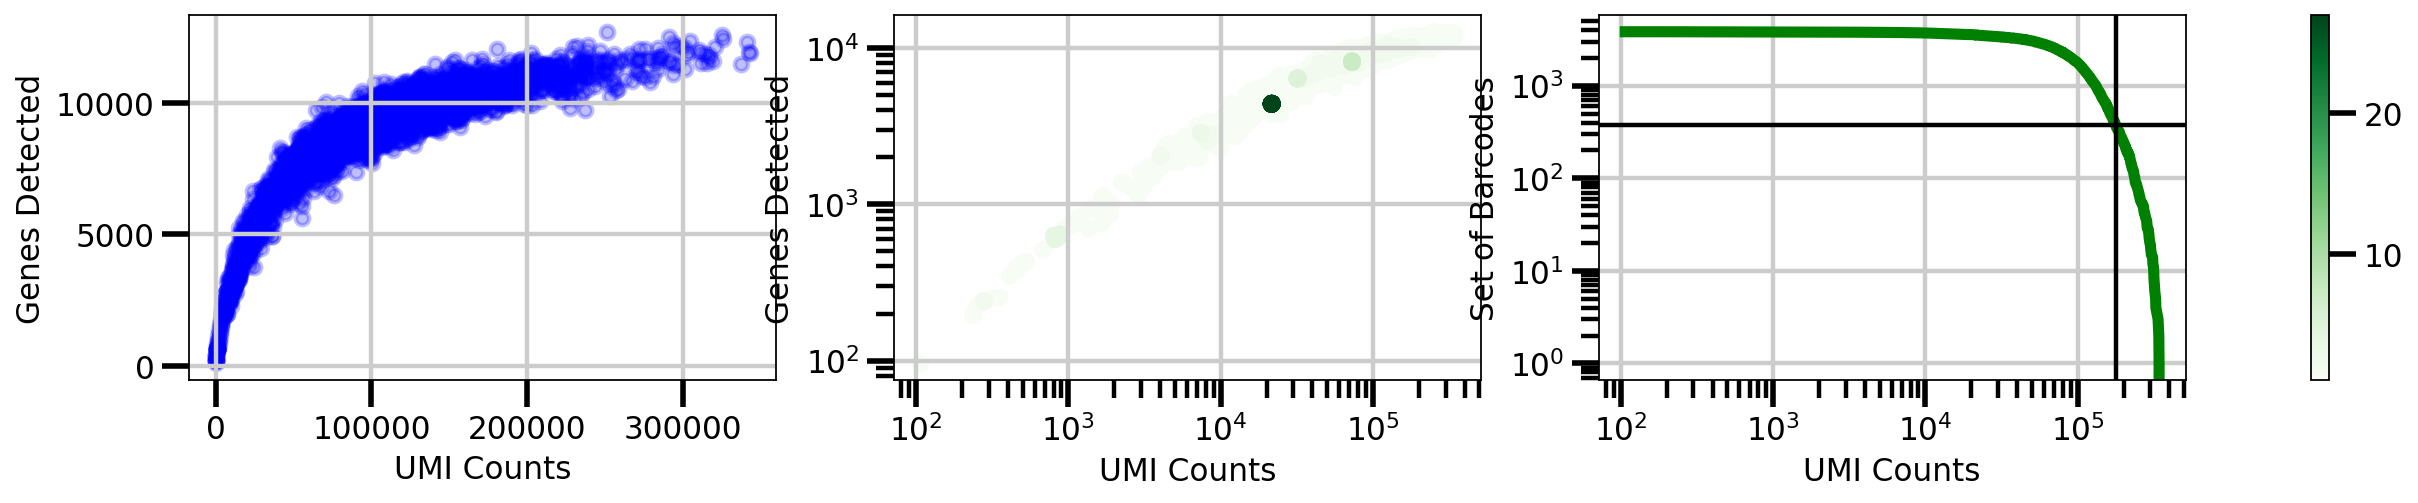

In [69]:
#### RECREATE PLOTS THAT ARE GIVEN IN THE REPORT BY SCILAB!

#Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(1,3)
x = np.asarray(adata.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(adata.X>0, axis=1))[:,0]
ax[0].scatter(x, y, color="b", alpha=0.25)
ax[0].set_ylabel("Genes Detected")
ax[0].set_xlabel("UMI Counts")
#ax.set_xscale('log')
#ax.set_yscale('log')

#histogram definition
bins = [1500, 1500] # number of bins
# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)
# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]

s = ax[1].scatter(x2, y2, c=z2, cmap='Greens')  
fig.colorbar(s, ax=ax)

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel("UMI Counts")
ax[1].set_ylabel("Genes Detected")


expected_num_cells =  380#@param {type:"integer"}
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

ax[2].loglog(knee, range(len(knee)), linewidth=5, color="g")
ax[2].axvline(x=knee[expected_num_cells], linewidth=2, color="k")
ax[2].axhline(y=expected_num_cells, linewidth=2, color="k")

ax[2].set_xlabel("UMI Counts")
ax[2].set_ylabel("Set of Barcodes")

#plt.grid(True, which="both")

fig.set_size_inches([20,3])
plt.show()
fig.savefig(os.path.join(figure_path , 'QC_UMI_genes_counts_pre_filtering.png'))

normalizing counts per cell
    finished (0:00:00)


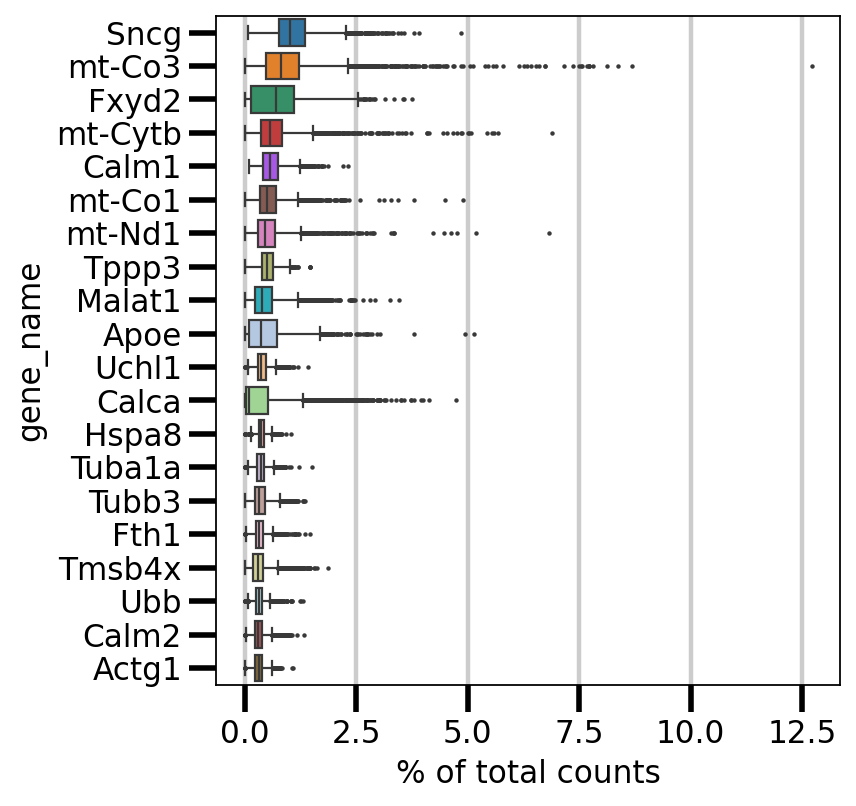

total mitochondrial: 13


In [70]:
### WE NEED TO CONVERT CODENAMES INTO REAL GENE NAMES
### FOR THAT WE USE T2G VARIABLE THAT OPENS T2G FILE (FILE WITH LINK BETWEEN GENE CODE AND GENE NAME)

# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(axis = 1) ## this sums over genes
x =  adata.X.sum(axis = 1)
adata.obs['log_counts'] = np.log(x)
adata.obs['n_genes'] = (adata.X > 0).sum(axis = 1)

sc.pl.highest_expr_genes(adata, n_top=20, )

# count mitochondrial genes
cnt = 0
for gene in adata.var["gene_name"].values:
    if gene.startswith('mt-'):
        cnt+=1
print(f"total mitochondrial: {cnt}")

In [71]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

#adata.var["gene_id"] = adata.var.index.values
#adata.var["gene_name"] = adata.var.gene_id.map(t2g["gene_name"])
#adata.var.index = adata.var["gene_name"]

#mt_gene_mask = np.flatnonzero([gene.startswith('mt-') for gene in adata.var_names])
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
#y = np.sum(adata[:, mt_gene_mask].X, axis=1).A1.reshape(-1,)
#z = np.array(adata.obs['n_counts']).reshape(-1,)

#adata.obs['mt_frac'] = y/z

#adata.var["mt"] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
#sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)
#sc.pl.highest_expr_genes(adata, n_top=10)

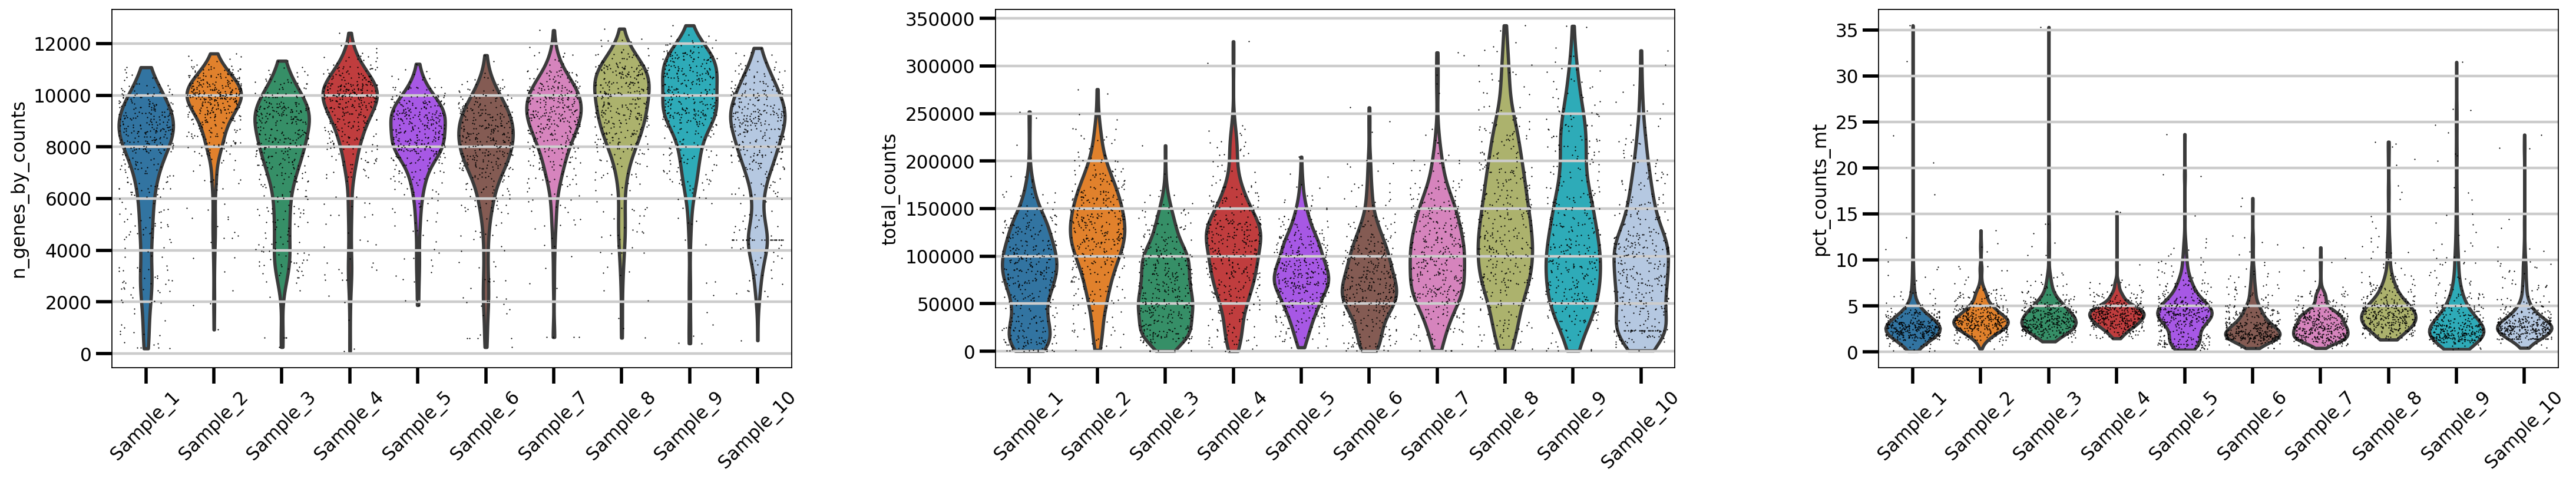

In [72]:
rcParams['figure.figsize']=(8,5)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, groupby = 'sample', rotation= 45)

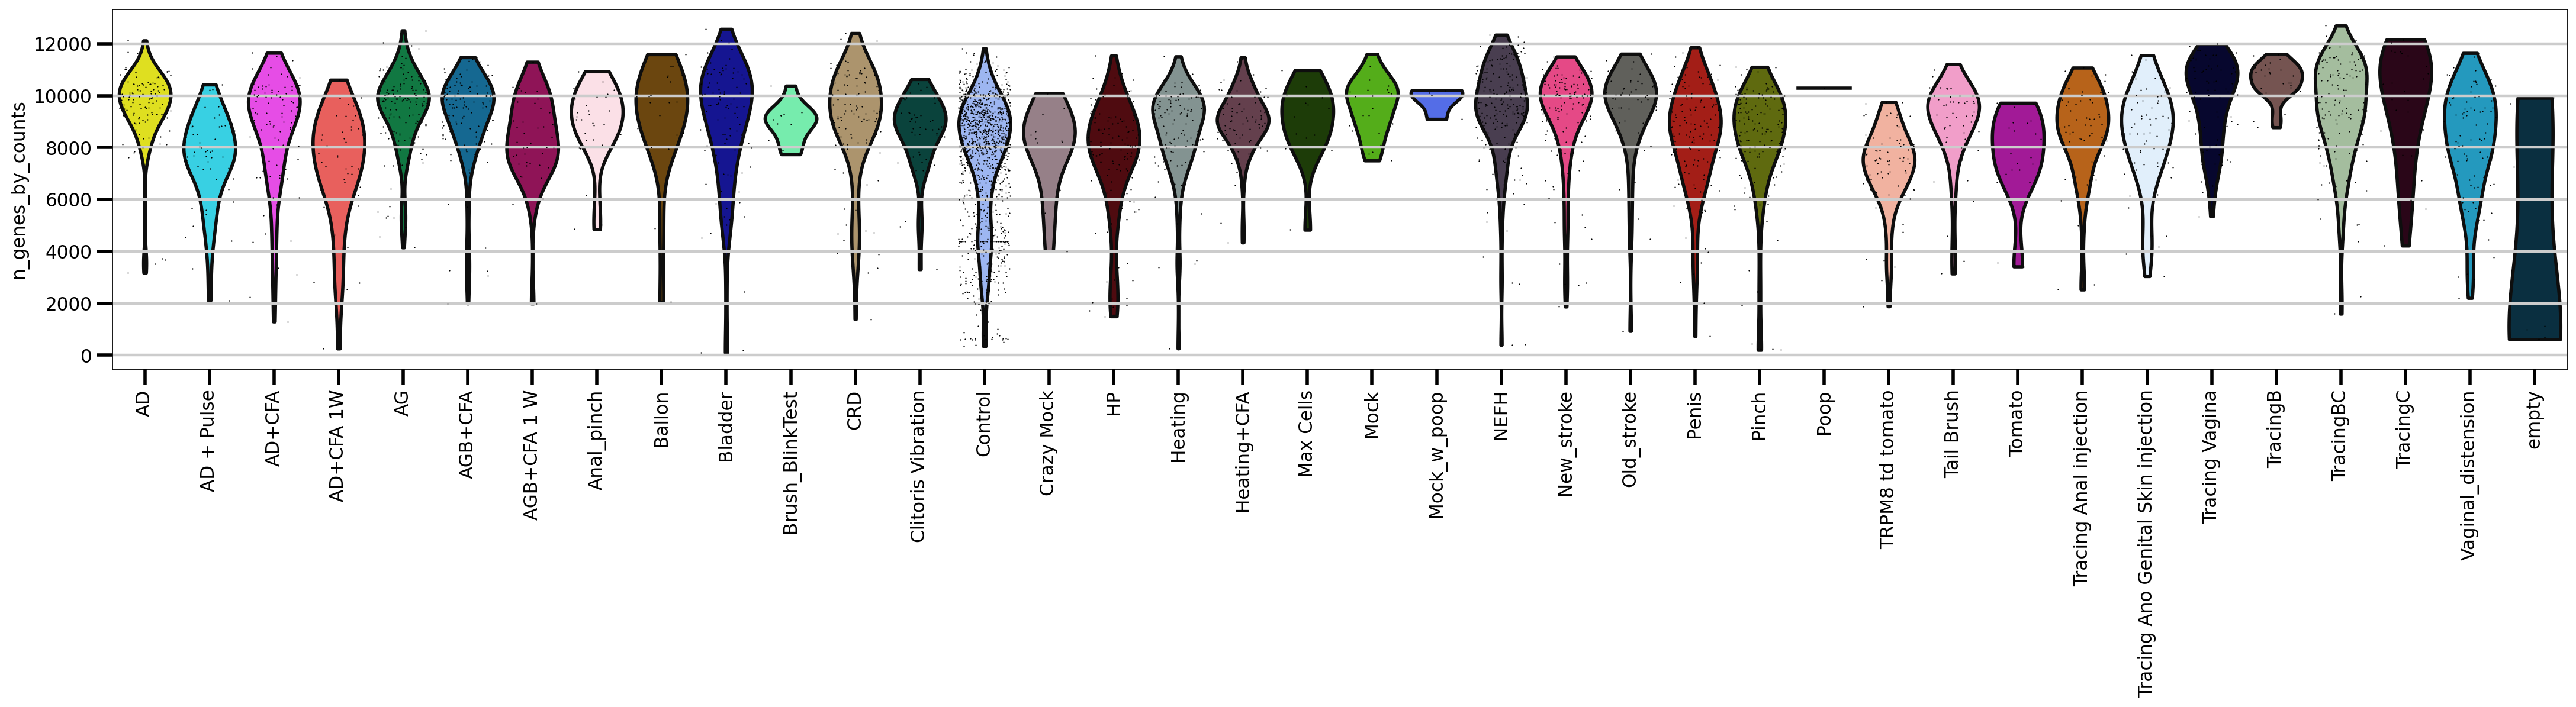

AD: 124 cells
AD + Pulse: 55 cells
AD+CFA: 99 cells
AD+CFA 1W: 47 cells
AG: 148 cells
AGB+CFA: 120 cells
AGB+CFA 1 W: 46 cells
Anal_pinch: 32 cells
Ballon: 23 cells
Bladder: 104 cells
Brush_BlinkTest: 11 cells
CRD: 106 cells
Clitoris Vibration: 51 cells
Control: 1135 cells
Crazy Mock: 14 cells
HP: 132 cells
Heating: 105 cells
Heating+CFA: 85 cells
Max Cells: 16 cells
Mock: 27 cells
Mock_w_poop: 4 cells
NEFH: 226 cells
New_stroke: 133 cells
Old_stroke: 56 cells
Penis: 136 cells
Pinch: 159 cells
Poop: 1 cells
TRPM8 td tomato: 81 cells
Tail Brush: 56 cells
Tomato: 22 cells
Tracing Anal injection: 59 cells
Tracing Ano Genital Skin injection: 64 cells
Tracing Vagina: 72 cells
TracingB: 30 cells
TracingBC: 133 cells
TracingC: 26 cells
Vaginal_distension: 95 cells
empty: 7 cells


In [73]:
rcParams['figure.figsize']=(25,5)
sc.pl.violin(adata, 'n_genes_by_counts', jitter=0.4, groupby = 'stimulus_name', rotation= 90)
# check how many of cells each stimulus has
my_stimuli = np.unique(adata.obs['stimulus_name'].values)
for stim in (my_stimuli):
    single_stim_data = adata[adata.obs['stimulus_name'] == stim]
    total_cells = len(single_stim_data.obs['stimulus_name'].values)
    print(f"{stim}: {total_cells} cells")

/home/melma31/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


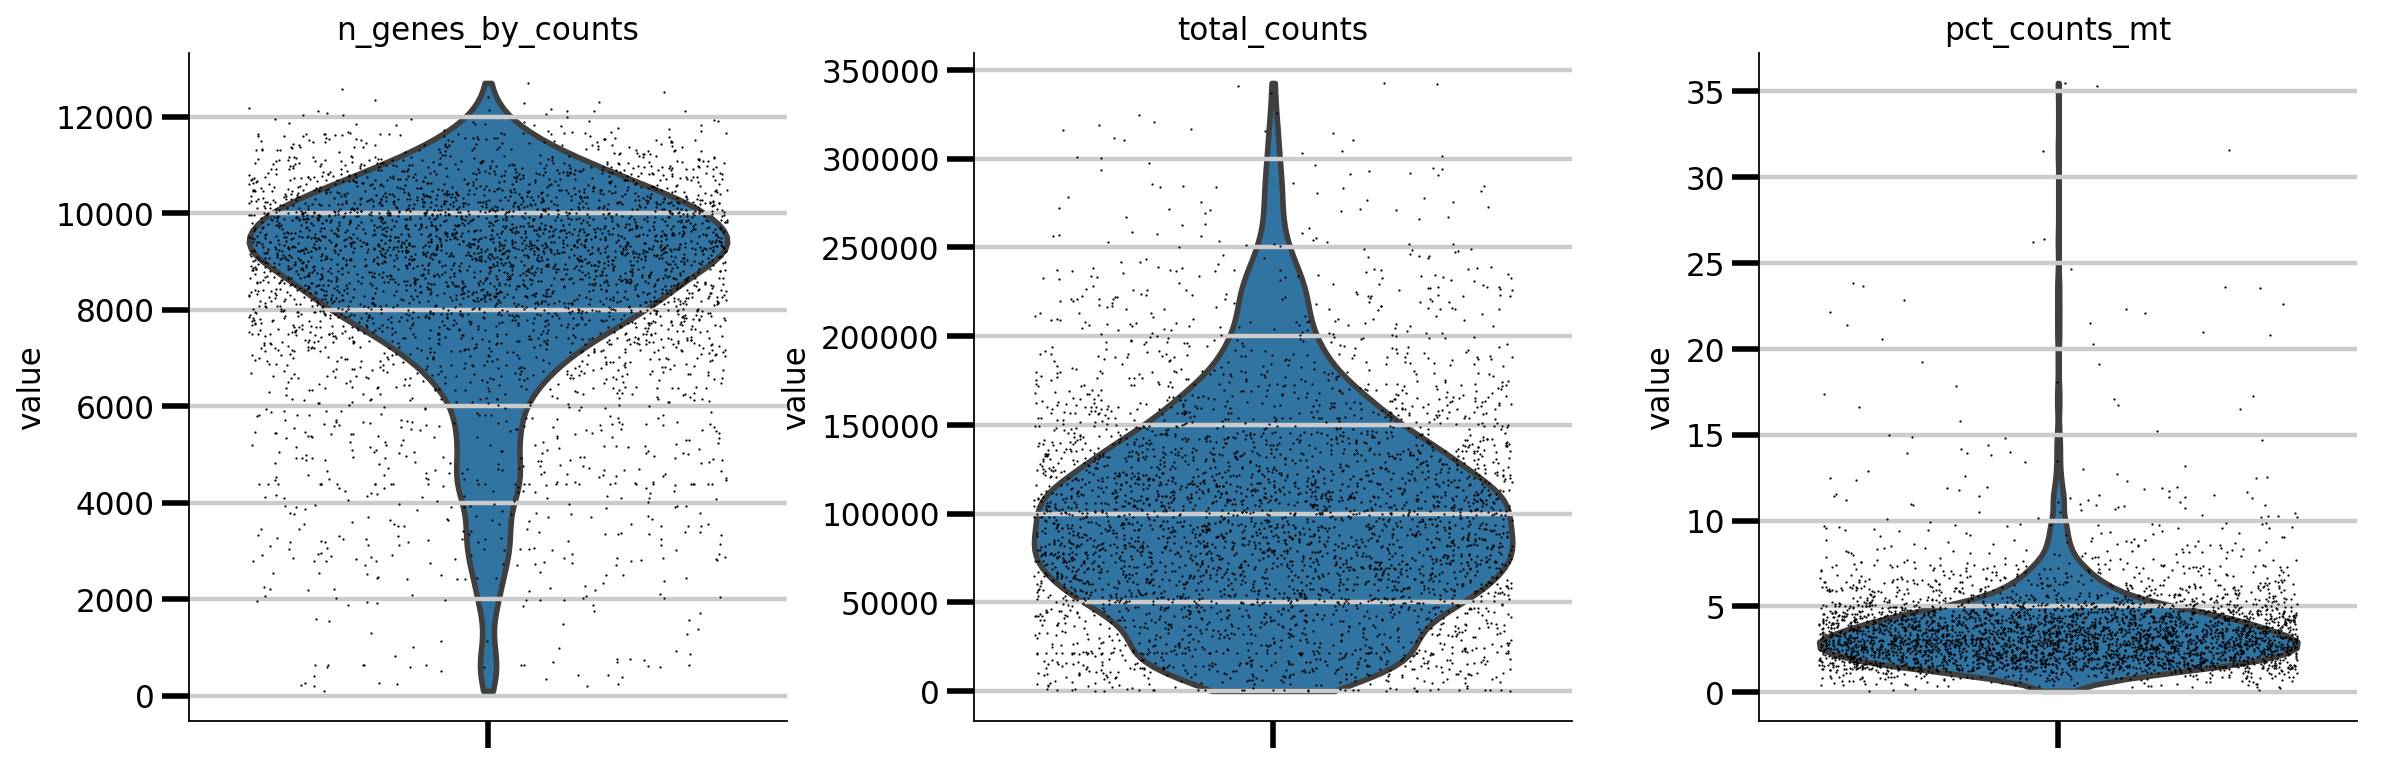

In [74]:
adata.var_names_make_unique()
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

### FILTERING QC

In [75]:
print('Number of cells before removing some mitochondrial: {:d}'.format(adata.n_obs))
# keep only below 5% mitochondrial
# Do the filtering by slicing the AnnData object
adata = adata[adata.obs.pct_counts_mt < mito_threshold, :]
print('Number of cells after removing some mitochondrial: {:d}'.format(adata.n_obs))

Number of cells before removing some mitochondrial: 3840
Number of cells after removing some mitochondrial: 3131


/tmp/ipykernel_30555/1263049107.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['fraction_mito'] = np.sum(
/home/melma31/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/melma31/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/melma31/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


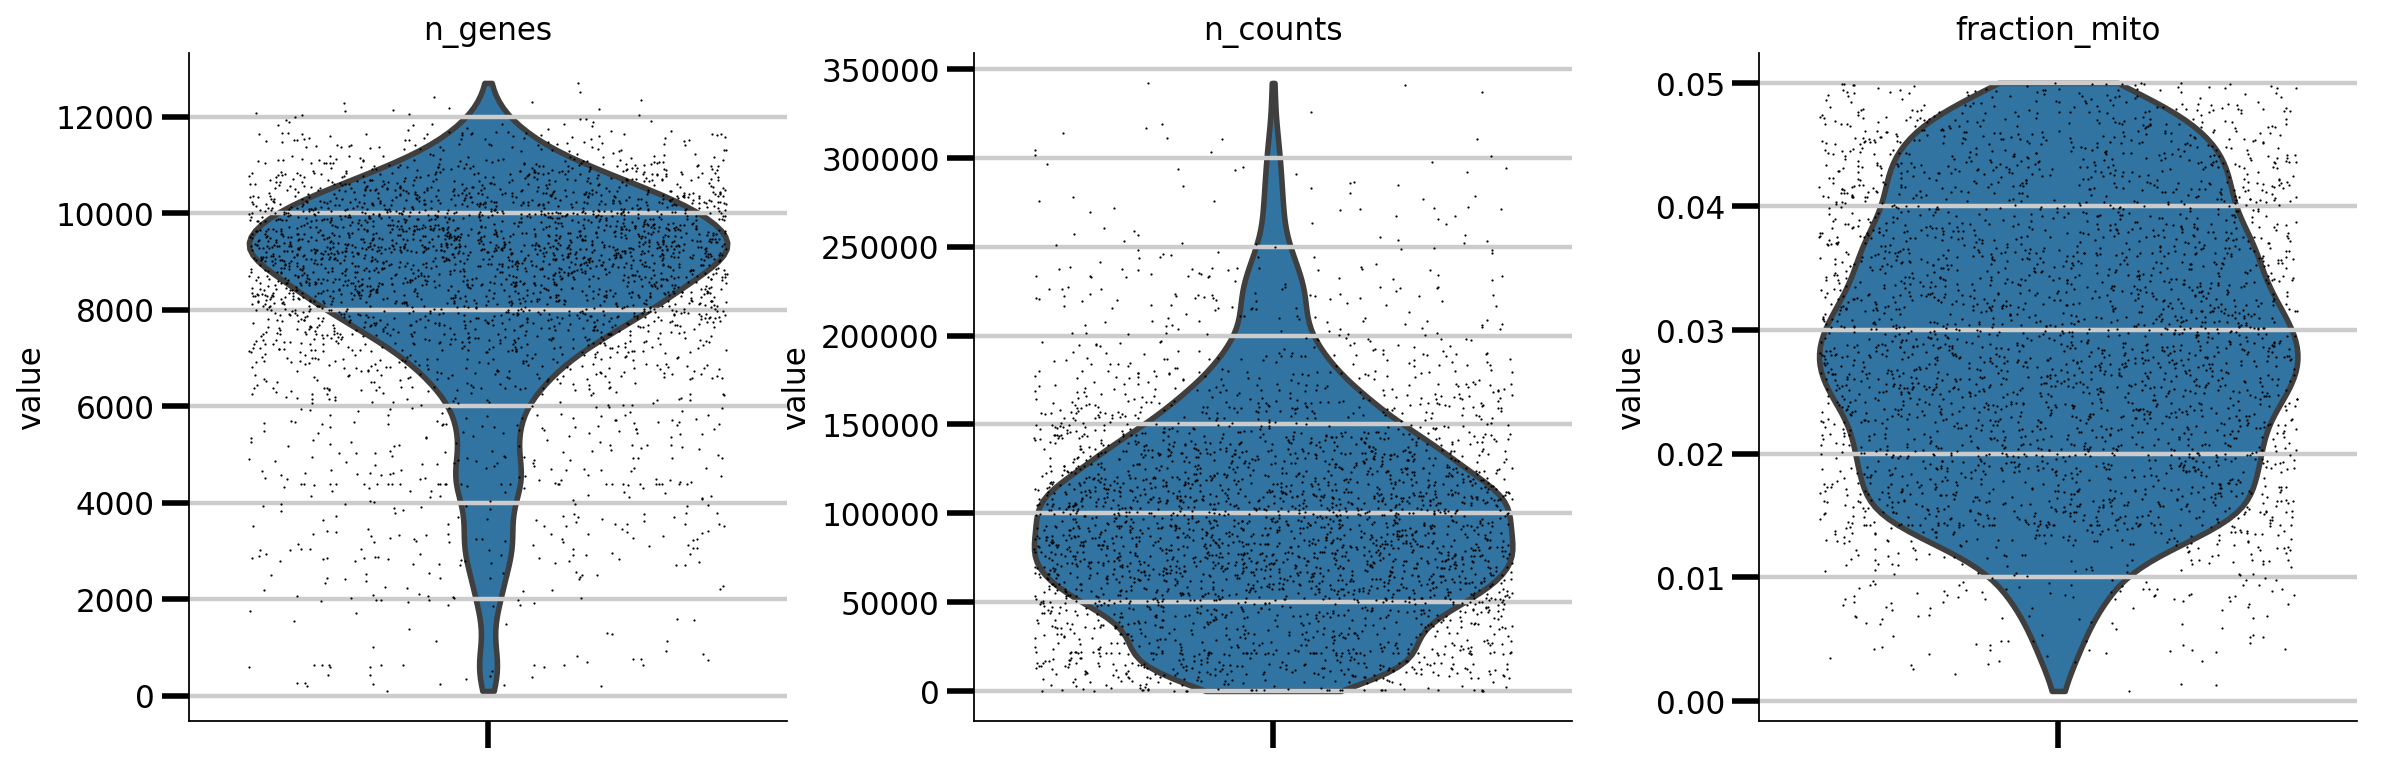

In [76]:
### check for mitochandrial mRNA
mito_genes = adata.var_names.str.startswith('mt-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)

#### change percent to fraction!!!!!

adata.obs['fraction_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
sc.pl.violin(adata, ['n_genes', 'n_counts', 'fraction_mito'],
             jitter=0.4, multi_panel=True)

normalizing counts per cell
    finished (0:00:00)


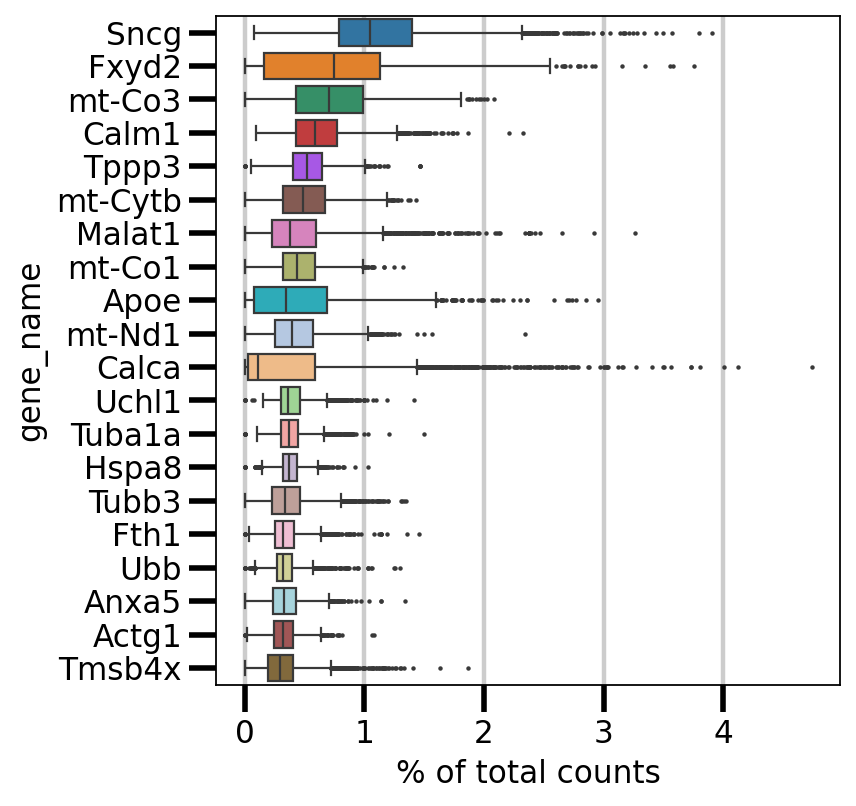

In [77]:
sc.pl.highest_expr_genes(adata, n_top=20, )


In [78]:
#Filter cells according to identified QC thresholds:
print('Total number of cells before: {:d}'.format(adata.n_obs))
#cell_subset = sc.pp.filter_cells(adata, min_counts = 1000)
#filter1 = kept_cells_stimuli[cell_subset[0]]
#red_filter1 = red_intensity[cell_subset[0]]
#green_filter1 = green_intensity[cell_subset[0]]
#well_id_filter1 = well_id[cell_subset[0]]
sc.pp.filter_cells(adata, min_counts = MIN_COUNTS)
print('Total number of cells after: {:d}'.format(adata.n_obs))

print('Number of cells after min count filter before: {:d}'.format(adata.n_obs))
#cell_subset = sc.pp.filter_cells(adata, min_genes = 1000,inplace=False)
#filter2 = filter1[cell_subset[0]]
#red_filter2 = red_filter1[cell_subset[0]]
#green_filter2 = green_filter1[cell_subset[0]]
#well_id_filter2 = well_id_filter1[cell_subset[0]]
sc.pp.filter_cells(adata, min_genes = MIN_GENES)
print('Number of cells after min count filter after: {:d}'.format(adata.n_obs))

#Filter genes:
print('Total number of genes before: {:d}'.format(adata.n_vars))
# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=MIN_CELLS)
print('Total number of genes after: {:d}'.format(adata.n_vars))

#sc.pp.filter_genes(adata, min_counts=10)
print(adata.shape)

Total number of cells before: 3131
filtered out 112 cells that have less than 10000 counts
Total number of cells after: 3019
Number of cells after min count filter before: 3019
filtered out 9 cells that have less than 3000 genes expressed


/home/melma31/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Number of cells after min count filter after: 3010
Total number of genes before: 34183
filtered out 11455 genes that are detected in less than 5 cells
Total number of genes after: 22728
(3010, 22728)


/home/melma31/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [79]:
#mito_list = []
#for i in range(len(adata.obs['fraction_mito'])):
#    mito_list.append(adata.obs['fraction_mito'][i])
#mito_list_thres = np.where(np.array(mito_list)<mito_threshold)[0]
#adata = adata[mito_list_thres,:]
#print(adata.shape)
#sc.pl.violin(adata, ['n_genes', 'n_counts', 'fraction_mito'],
#             jitter=0.4, multi_panel=True)
# keep only below 5% mitochondrial

# Actually do the filtering by slicing the AnnData object
print('Number of cells before: {:d}'.format(adata.n_obs))
# keep only below 5% mitochondrial
adata = adata[adata.obs.pct_counts_mt < 5, :]
print('Number of cells after: {:d}'.format(adata.n_obs))

#adata = adata[adata.obs.pct_counts_mt < mito_threshold * 100, :]
#print('Number of cells after: {:d}'.format(adata.n_obs))

Number of cells before: 3010
Number of cells after: 3010


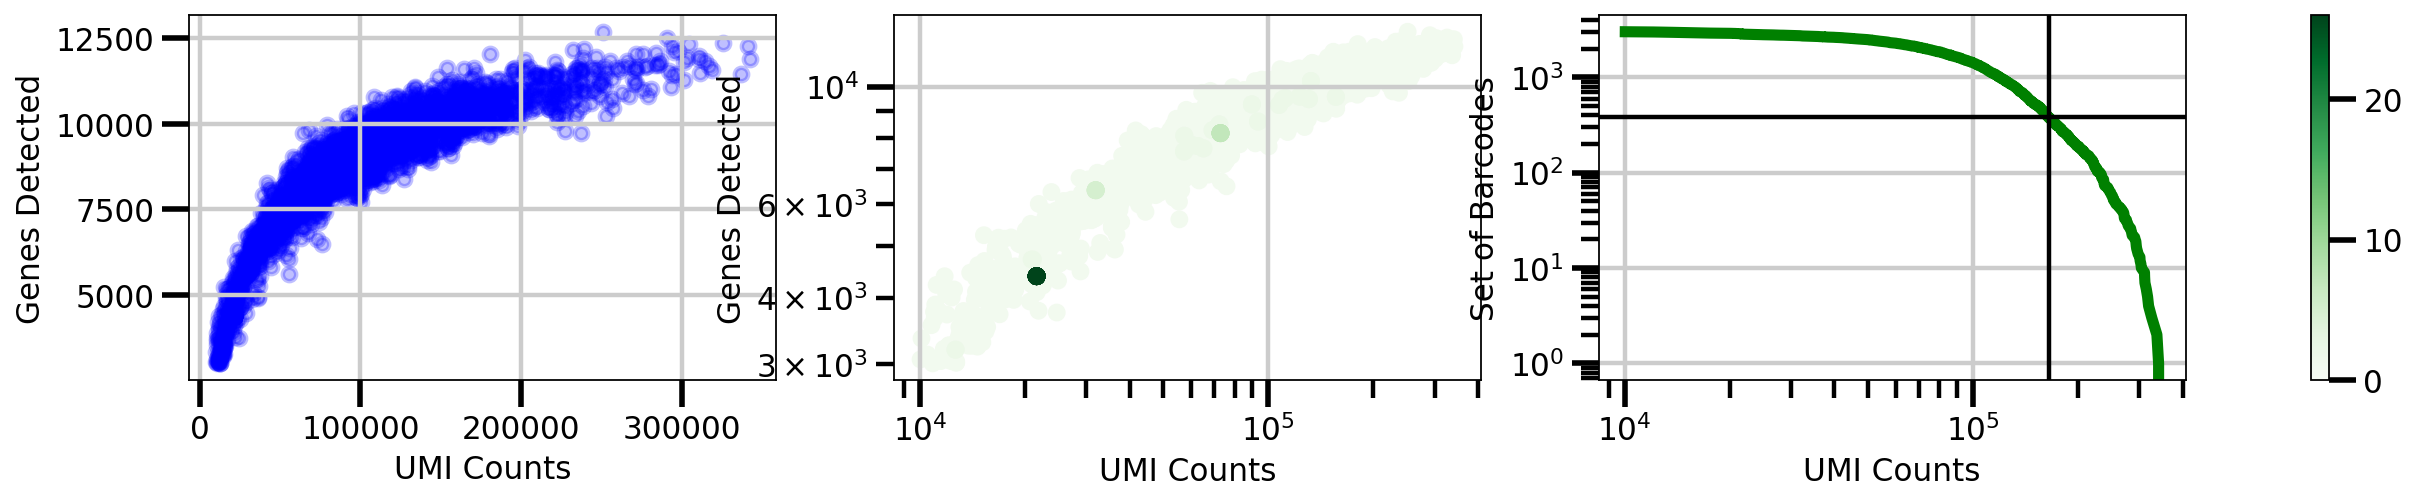

In [80]:
#Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(1,3)
x = np.asarray(adata.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(adata.X>0, axis=1))[:,0]
ax[0].scatter(x, y, color="b", alpha=0.25)
ax[0].set_ylabel("Genes Detected")
ax[0].set_xlabel("UMI Counts")
#ax.set_xscale('log')
#ax.set_yscale('log')

#histogram definition
bins = [1500, 1500] # number of bins
# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)
# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]

s = ax[1].scatter(x2, y2, c=z2, cmap='Greens')  
fig.colorbar(s, ax=ax)

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel("UMI Counts")
ax[1].set_ylabel("Genes Detected")


expected_num_cells =  380#@param {type:"integer"}
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

ax[2].loglog(knee, range(len(knee)), linewidth=5, color="g")
ax[2].axvline(x=knee[expected_num_cells], linewidth=2, color="k")
ax[2].axhline(y=expected_num_cells, linewidth=2, color="k")

ax[2].set_xlabel("UMI Counts")
ax[2].set_ylabel("Set of Barcodes")

#plt.grid(True, which="both")

fig.set_size_inches([20,3])
plt.show()
fig.savefig(os.path.join(figure_path , 'QC_UMI_genes_counts.png'))

In [81]:
!pip install hdf5plugin
import hdf5plugin

adata.var_names_make_unique() 

adata.write_h5ad(
    os.path.join(output_path , 'campari_scs_all_genes.h5ad'),
#    compression=hdf5plugin.FILTERS["zstd"],
#    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)

### Normalization, logaritmization and selection of Highly variable genes

In [82]:
#print(adata.shape)
#adata = adata[adata.obs.n_genes_by_counts < N_GENES_BY_COUNTS, :]
#print(adata.shape)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 16000


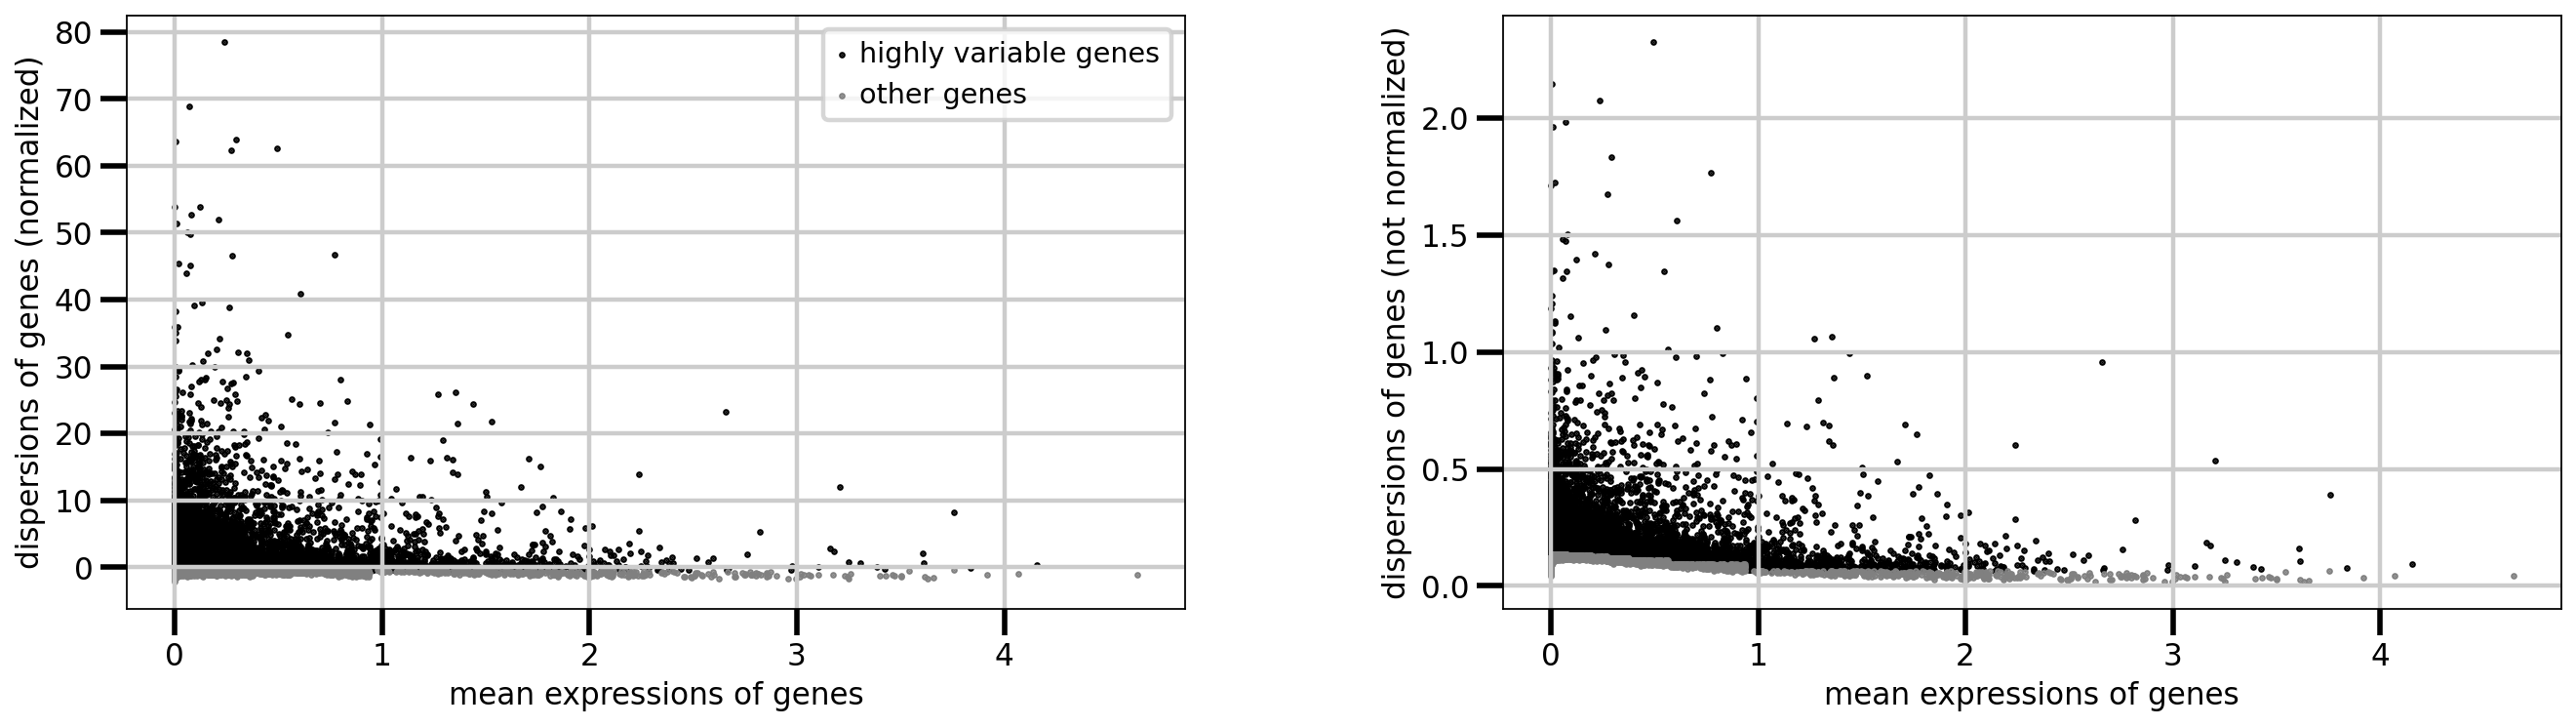

(3010, 22728)


In [83]:
from matplotlib import rcParams
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes= HIGHLY_VARIABLE_GENES)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))
rcParams['figure.figsize']=(10,5)
sc.pl.highly_variable_genes(adata)
print(adata.shape)

(3010, 16000)


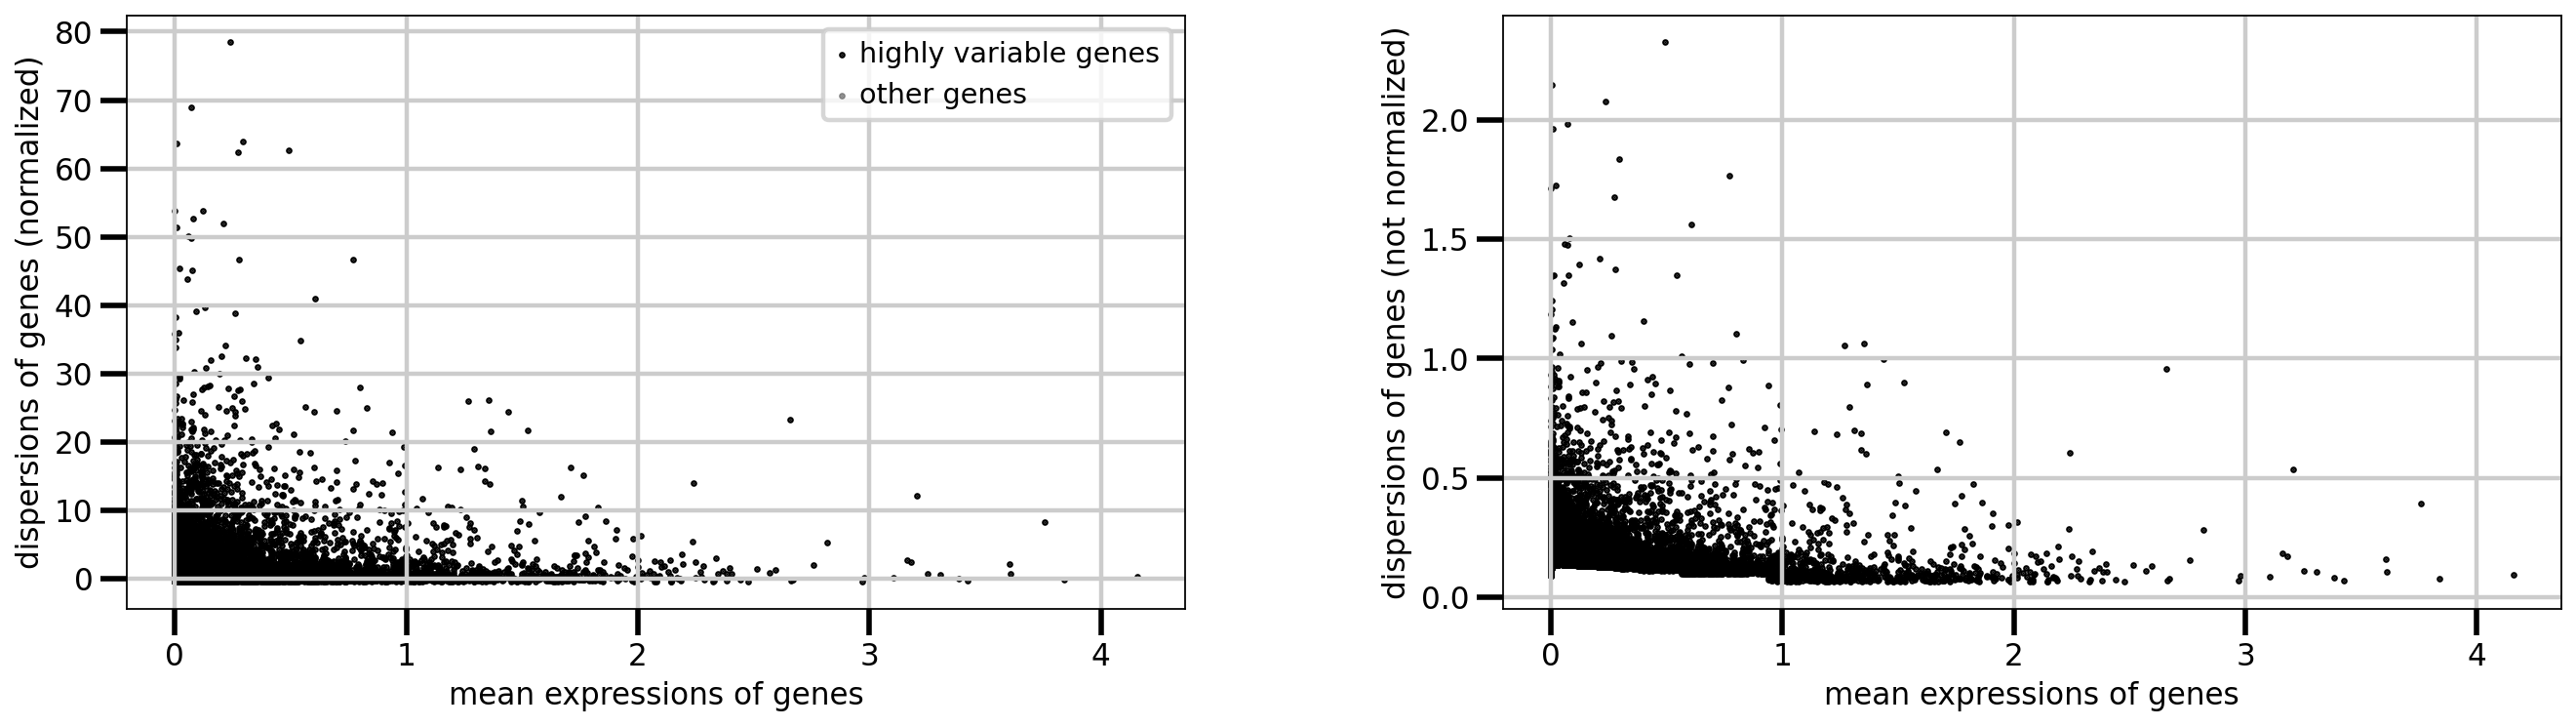

In [84]:
adata = adata[:, adata.var.highly_variable]
print(adata.shape)
sc.pl.highly_variable_genes(adata)

In [85]:
#x_all = scipy.sparse.csr_matrix.toarray(adata.X)
#figure, axes = plt.subplots()
#axes.hist(x_all[:,100])

In [86]:
### check again regress_out!!!!!

sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
#sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/home/melma31/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:657: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/melma31/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    finished (0:00:37)


In [87]:
#x_all = adata.X
#figure, axes = plt.subplots()
#axes.hist(x_all[:,100])

In [88]:
sc.pp.scale(adata, max_value=10)

In [89]:
adata.write_h5ad(
    os.path.join(output_path , 'campari_scs.h5ad'))
#    compression=hdf5plugin.FILTERS["zstd"])
#    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options)
#adata.write(output_path + 'campari_scs.h5ad')

In [90]:
adata.shape

(3010, 16000)